In [42]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Use pygeos in geopandas
os.environ['USE_PYGEOS'] = '0'

import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from tqdm.auto import tqdm

from gensit.utils import *
from gensit.utils.notebook_functions import *

%matplotlib inline

# AUTO RELOAD EXTERNAL MODULES
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset summaries

In [43]:
# Print data summary
all_datasets = ['DC','Chi','LA','NYC','San','Sea']

for ds in all_datasets:
    ds_table_filename = f'od/{ds}/od_2015.npy'
    ds_train_index_filename = f'od/{ds}/train_index.pkl'
    ds_test_index_filename = f'od/{ds}/test_index.pkl'
    ds_validation_index_filename = f'od/{ds}/valid_index.pkl'
    base_path = '../../od_construction_benchmarks/methods/ANN/data/'

    # Define directory
    ds_table_path = os.path.join(base_path,ds_table_filename)
    ds_train_index_path = os.path.join(base_path,ds_train_index_filename)
    ds_test_index_path = os.path.join(base_path,ds_test_index_filename)
    ds_validation_index_path = os.path.join(base_path,ds_validation_index_filename)

    ds_table = np.load(ds_table_path)
    with open(ds_train_index_path, 'rb') as f:
        ds_train_index = pickle.load(f)
    with open(ds_test_index_path, 'rb') as f:
        ds_test_index = pickle.load(f)
    with open(ds_validation_index_path, 'rb') as f:
        ds_validation_index = pickle.load(f)
    ds_zero_cells = np.argwhere(ds_table==0)
    ds_train_cells = np.array(ds_train_index).T
    ds_test_cells = np.array(ds_test_index).T
    ds_validation_cells = np.array(ds_validation_index).T
    ds_zero_and_train_cells = np.concatenate((np.argwhere(ds_table==0),ds_train_cells))
    ds_test_validation_cells = np.concatenate((ds_test_cells,ds_validation_cells))
    nrows,ncols = np.shape(ds_table)

    print(f"{ds} dataset | I: {nrows}, J: {ncols}, Total: {ds_table.sum()}")
    print(f"Total cells: {nrows*ncols}")
    print(f"Train cells: {len(ds_train_cells)}, Zero cells: {len(ds_zero_cells)}, Train/zero cells: {len(ds_zero_and_train_cells)}")
    print(f"Test cells: {len(ds_test_cells)}, Test/Validation cells: {len(ds_test_validation_cells)}")
    print(f"Sanity check: {len(ds_zero_and_train_cells)+len(ds_test_validation_cells)} = {nrows*ncols}")
    print('\n')

DC dataset | I: 179, J: 179, Total: 200029.0
Total cells: 32041
Train cells: 9982, Zero cells: 15403, Train/zero cells: 25385
Test cells: 3328, Test/Validation cells: 6656
Sanity check: 32041 = 32041


Chi dataset | I: 1985, J: 1985, Total: 3722478.0
Total cells: 3940225
Train cells: 562518, Zero cells: 3002694, Train/zero cells: 3565212
Test cells: 187507, Test/Validation cells: 375013
Sanity check: 3940225 = 3940225


LA dataset | I: 3342, J: 3342, Total: 5283241.0
Total cells: 11168964
Train cells: 1055068, Zero cells: 9410517, Train/zero cells: 10465585
Test cells: 351690, Test/Validation cells: 703379
Sanity check: 11168964 = 11168964


NYC dataset | I: 2168, J: 2168, Total: 3031641.0
Total cells: 4700224
Train cells: 543502, Zero cells: 3794387, Train/zero cells: 4337889
Test cells: 181167, Test/Validation cells: 362335
Sanity check: 4700224 = 4700224


San dataset | I: 197, J: 197, Total: 283179.0
Total cells: 38809
Train cells: 15453, Zero cells: 13053, Train/zero cells: 28506


## Import table and geometries

In [44]:
dataset = f'DC'
table_filename = f'od/{dataset}/od_2015.npy'
cost_filename = f'adj/{dataset}/distance.npy'
region_features_filename = f'region_features_{dataset}.csv'
region_geometries_filename = f'region_geometries_{dataset}.geojson'
neighbours_filename = f"adj/{dataset}/neighbors.npy"
train_index_filename = f'od/{dataset}/train_index.pkl'
test_index_filename = f'od/{dataset}/test_index.pkl'
validation_index_filename = f'od/{dataset}/valid_index.pkl'
base_path = '../../od_construction_benchmarks/methods/ANN/data/'

# Define directory
table_path = os.path.join(base_path,table_filename)
cost_path = os.path.join(base_path,cost_filename)
region_features_path = os.path.join(base_path,region_features_filename)
region_geometries_path = os.path.join(base_path,region_geometries_filename)
neighbours_path = os.path.join(base_path,neighbours_filename)
train_index_path = os.path.join(base_path,train_index_filename)
test_index_path = os.path.join(base_path,test_index_filename)
validation_index_path = os.path.join(base_path,validation_index_filename)

In [45]:
table = np.load(table_path)
I,J = np.shape(table)
rowsums,colsums = table.sum(axis=1),table.sum(axis=0)
region_features = pd.read_csv(region_features_path)
region_geometries = gpd.read_file(region_geometries_path)
region_geometries = region_geometries.set_index('GEOID')
region_geometries.index = region_geometries.index.astype(int)
region_geometries = region_geometries.sort_index()
region_geometries['LOCATIONID'] = list(range(1,I+1))
cost = np.load(cost_path)
neighbours = np.load(neighbours_path)
with open(train_index_path, 'rb') as f:
    train_index = pickle.load(f)
with open(test_index_path, 'rb') as f:
    test_index = pickle.load(f)
with open(validation_index_path, 'rb') as f:
    validation_index = pickle.load(f)
cost_large_diagonal = cost + np.eye(J)*1000

adjacency_matrix = (neighbours+np.eye(I)).astype('int8')
cost_weigthed_adjacency_matrix = np.where(adjacency_matrix,cost,np.nan)

In [47]:
region_features = region_features.reset_index().rename(columns={'Unnamed: 0':'GEOID'}).set_index('GEOID')
# Sanity checks
try:
    assert region_features.index.is_monotonic_increasing
except:
    print("Region features not monotonic")

# Keep only a subset of the data
mini_region_features = deepcopy(region_features.reset_index()[["GEOID","Estimate!!Total housing units"]])

In [50]:
region_features_with_origin_demand = deepcopy(region_features)
mini_region_features_with_origin_demand = deepcopy(mini_region_features)
region_features_with_origin_and_destination_demand = deepcopy(region_features)
mini_region_features_with_origin_and_destination_demand = deepcopy(mini_region_features)

region_features_with_origin_demand['Origin_Demand'] = rowsums
mini_region_features_with_origin_demand['Origin_Demand'] = rowsums
region_features_with_origin_and_destination_demand['Origin_Demand'] = rowsums
mini_region_features_with_origin_and_destination_demand['Origin_Demand'] = rowsums

region_features_with_origin_and_destination_demand['Destination_Demand'] = colsums
mini_region_features_with_origin_and_destination_demand['Destination_Demand'] = colsums

In [49]:
dataset,I,J,table.sum()

('DC', 179, 179, 200029.0)

In [16]:
zero_cells = np.argwhere(table==0)
train_cells = np.array(train_index).T
test_cells = np.array(test_index).T
validation_cells = np.array(validation_index).T
zero_and_train_cells = np.concatenate((np.argwhere(table==0),train_cells))
test_validation_cells = np.concatenate((test_cells,validation_cells))

In [17]:
# Number of zeros by column
zeros_by_col = (region_features == 0).astype(int).sum(axis=0).to_dict()
zeros_by_col = {k:v for k,v in zeros_by_col.items() if v <= 0}
zeros_by_col

{'Estimate!!Total housing units': 0,
 'Estimate!!SEX AND AGE!!Total population': 0,
 'Estimate!!SEX AND AGE!!Total population!!Male': 0,
 'Estimate!!SEX AND AGE!!Total population!!Female': 0,
 'Estimate!!SEX AND AGE!!18 years and over': 0,
 'Estimate!!SEX AND AGE!!21 years and over': 0,
 'Estimate!!SEX AND AGE!!Median age (years)': 0,
 "Total!!Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college or associate's degree": 0,
 "Total!!Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college or associate's degree.1": 0,
 'Total!!Estimate!!POVERTY STATUS IN THE PAST 12 MONTHS!!Population for whom poverty status is determined!!At or above 150 percent of the poverty level': 0,
 'Total!!Estimate!!HOUSEHOLDS!!Households': 0,
 'Join_Count6': 0}

In [18]:
destination_attraction_attrs = {
    "households":"Total!!Estimate!!HOUSEHOLDS!!Households",
    "housing_units":"Estimate!!Total housing units",
    "population":"Estimate!!SEX AND AGE!!Total population"
}

destination_attractions = {}
for da_attr,colname in destination_attraction_attrs.items():
    destination_attractions[da_attr] = region_features[colname].values
destination_attractions["demand"] = table.sum(axis=0)

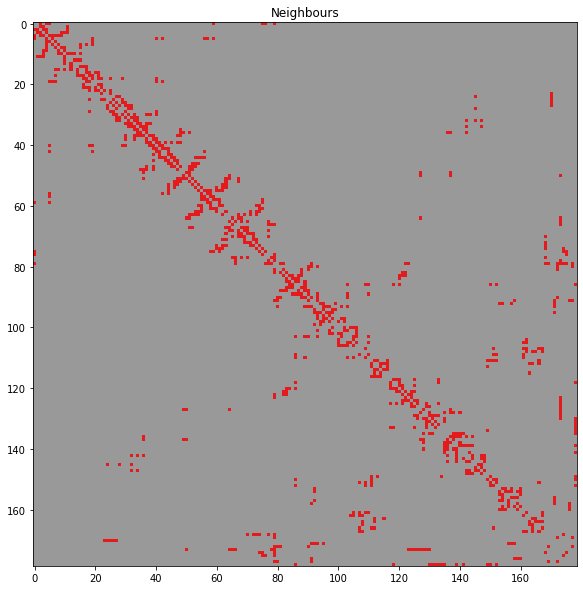

In [19]:
plt.figure(figsize=(10,10))
plt.title('Neighbours')
plt.imshow(neighbours, cmap='Set1_r', interpolation='nearest')
plt.show()

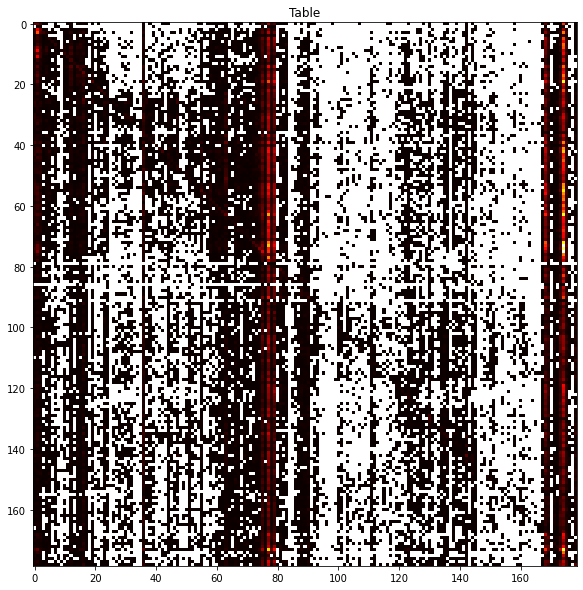

In [20]:
plt.figure(figsize=(10,10))
plt.title('Table')
plt.imshow(np.where(table<=0,np.nan,table), cmap='hot', interpolation='nearest')
plt.show()

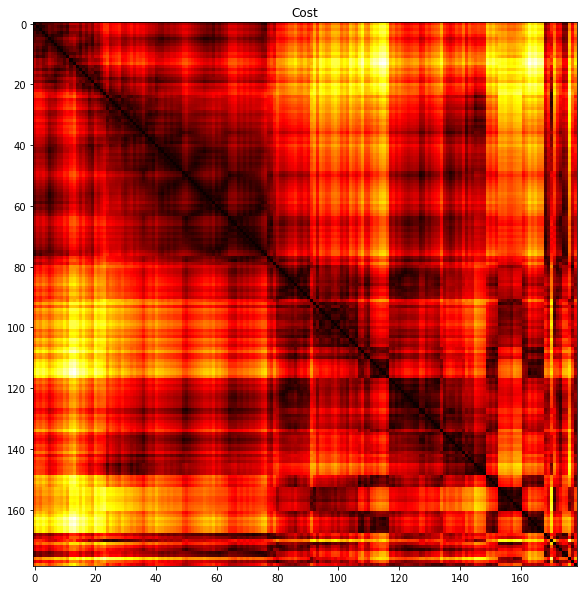

In [21]:
plt.figure(figsize=(10,10))
plt.title('Cost')
plt.imshow(cost, cmap='hot', interpolation='nearest')
plt.show()

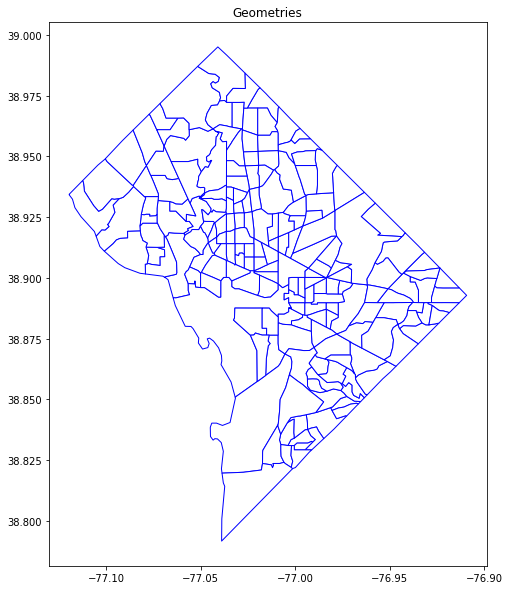

In [57]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.title('Geometries')
_ = region_geometries.plot(ax=ax,edgecolor='blue',facecolor='white')

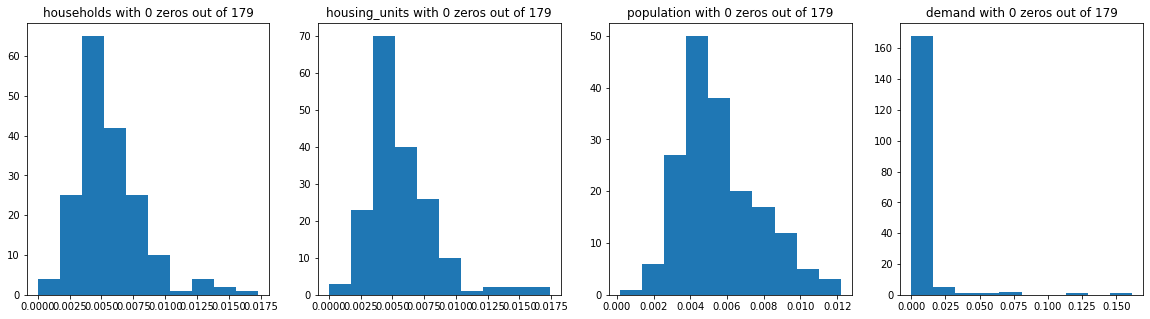

In [23]:
fig,axs = plt.subplots(1,len(destination_attractions),figsize=(5*len(destination_attractions),5))

for i,keyval in enumerate(destination_attractions.items()):
    axs[i].set_title(f"{keyval[0]} with {sum(keyval[1]<=0)} zeros out of {len(keyval[1])}")
    _ = axs[i].hist((keyval[1]/keyval[1].sum()).ravel())

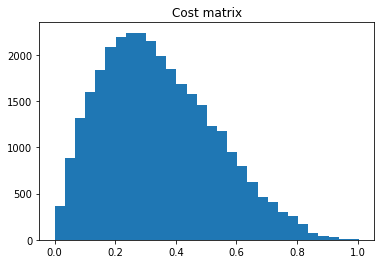

In [24]:
plt.title("Cost matrix")
_ = plt.hist(10994*(cost/cost.sum()).ravel(),bins=30)

# Normalise data

In [25]:
origin_demand_sum_normalised = rowsums/rowsums.sum()
cost_max_normalised = cost/cost.max()
cost_sum_normalised = cost/cost.sum()
cost_large_diagonal_sum_normalised = cost_large_diagonal/cost_large_diagonal.sum()
cost_large_diagonal_max_normalised = cost_large_diagonal/cost_large_diagonal.max()

destination_attractions_sum_normalised = {}
for da_name, da_data in destination_attractions.items():
    destination_attractions_sum_normalised[f"destination_attraction_{da_name}_ts_sum_normalised"] = da_data/da_data.sum()

# Export data to file

In [56]:
# os.mkdir(f"../data/inputs/{dataset}")

np.savetxt(f'../data/inputs/{dataset}/ground_truth_table.txt',table)
np.savetxt(f'../data/inputs/{dataset}/rowsums.txt',rowsums)
np.savetxt(f'../data/inputs/{dataset}/colsums.txt',colsums)
np.savetxt(f'../data/inputs/{dataset}/zero_cells.txt',zero_cells)
np.savetxt(f'../data/inputs/{dataset}/train_cells.txt',train_cells)
np.savetxt(f'../data/inputs/{dataset}/zero_and_train_cells.txt',zero_and_train_cells)
np.savetxt(f'../data/inputs/{dataset}/test_cells.txt',test_cells)
np.savetxt(f'../data/inputs/{dataset}/validation_cells.txt',validation_cells)
np.savetxt(f'../data/inputs/{dataset}/test_and_validation_cells.txt',test_validation_cells)
np.savetxt(f'../data/inputs/{dataset}/origin_demand_sum_normalised.txt',origin_demand_sum_normalised)

np.save(f'../data/inputs/{dataset}/region_features.npy',region_features.to_numpy())
np.save(f'../data/inputs/{dataset}/mini_region_features.npy',mini_region_features.to_numpy())
np.save(f'../data/inputs/{dataset}/region_features_with_origin_demand.npy',region_features_with_origin_demand.to_numpy())
np.save(f'../data/inputs/{dataset}/mini_region_features_with_origin_demand.npy',mini_region_features_with_origin_demand.to_numpy())
np.save(f'../data/inputs/{dataset}/region_features_with_origin_and_destination_demand.npy',region_features_with_origin_and_destination_demand.to_numpy())
np.save(f'../data/inputs/{dataset}/mini_region_features_with_origin_and_destination_demand.npy',mini_region_features_with_origin_and_destination_demand.to_numpy())
region_geometries.to_file(f'../data/inputs/{dataset}/region_geometries.geojson')

np.savetxt(f'../data/inputs/{dataset}/cost_matrix_max_normalised.txt',cost_max_normalised)
np.savetxt(f'../data/inputs/{dataset}/cost_matrix_sum_normalised.txt',cost_sum_normalised)
np.savetxt(f'../data/inputs/{dataset}/cost_matrix.txt',cost)
np.savetxt(f'../data/inputs/{dataset}/cost_matrix_large_diagonal_sum_normalised.txt',cost_large_diagonal_sum_normalised)
np.savetxt(f'../data/inputs/{dataset}/cost_matrix_large_diagonal_max_normalised.txt',cost_large_diagonal_max_normalised)
np.savetxt(f'../data/inputs/{dataset}/cost_matrix_large_diagonal.txt',cost_large_diagonal)

np.savetxt(f'../data/inputs/{dataset}/adjacency_matrix.txt',adjacency_matrix,fmt='%i')
np.savetxt(f'../data/inputs/{dataset}/cost_weigthed_adjacency_matrix.txt',cost_weigthed_adjacency_matrix)



for da_filename, da_data in destination_attractions_sum_normalised.items():
    np.savetxt(f'../data/inputs/{dataset}/{da_filename}.txt',da_data[:,np.newaxis])